In [1]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.locally_sparse_noise import LocallySparseNoise
from stimulus_analysis.timing_utils import find_nearest, get_frame_window_from_time_window
from statsmodels.sandbox.stats.multicomp import multipletests

%load_ext autoreload
%autoreload 2

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_26689/4042779375.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# windows
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"

# # linux and mac
# base_folder = "/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = V1DDClient(base_folder)

In [3]:
mouse = 409828
col, vol = 1, 3
sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
plane = sess.get_planes()[0]
print(f"Analyzing plane {plane}")

Analyzing plane 1


In [5]:
lsn = LocallySparseNoise(sess, plane)

In [6]:
lsn.sweep_responses.shape

(1705, 1234)

In [7]:
lsn.design_matrix.shape

(224, 1705)

In [8]:
lsn.image_shape

(8, 14)

In [97]:

design_matrix.shape

(1705, 224)

In [78]:
lsn.frame_images[0].flatten()

array([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127,   0, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127,   0, 127, 127, 127, 127, 255, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
         0, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 255, 127], dtype=uint8)

In [104]:
lsn.stim_meta

{'duration': 0.33, 'padding': 0, 'grid_size': 9.3, 'num_samples': 1705}

In [28]:
"""
Created on Thu Sep 20 15:16:53 2018
@author: danielm
"""
import numpy as np

def chi_square_RFs(responses,LSN_template,num_shuffles=1000, disk_mask_radius=2):
    
    #responses: numpy array with shape (num_trials,num_cells)
    #LSN_template: numpy array with shape (num_trials,num_y,num_x)
    
    num_trials = np.shape(responses)[0]
    num_cells = np.shape(responses)[1]        
    num_y = np.shape(LSN_template)[1]
    num_x = np.shape(LSN_template)[2]

    assert num_trials == np.shape(LSN_template)[0]

    #remove negative responses:
    responses = np.where(responses>=0.0,responses,0.0)

    #define the masks for exclusion regions we'll calculate the chi sq sum over
    masks = get_disc_masks(LSN_template, radius=disk_mask_radius)
    
    # build a binary matrix of pixels displayed on each trial
    trial_matrix, trials_per_pixel = build_trial_matrix(LSN_template)
    
    #pre-calculate 'expected' once, since it doesn't change with shuffling 
    mean_events_per_trial = np.mean(responses,axis=0)
    expected_by_pixel = trials_per_pixel.reshape(1,num_y,num_x,2) * mean_events_per_trial.reshape(num_cells,1,1,1)#shape is (num_cells,num_y,num_x,2) 
    expected_by_pixel = expected_by_pixel.reshape(num_cells,num_y*num_x*2,1)
    
    #more convenient to keep cells as axis 0
    responses = responses.T
    
    #calculate the contribution of each pixel to the chi_sum test statistic,
    # for the actual data as well as shuffles
    chi_actual, chi_shuffle = chi_square_across_template(responses,expected_by_pixel,trial_matrix,num_shuffles)
    
    #apply region masks around each pixel to sum pixel-wise chi contributions
    # to the chi_sum test statistic, then calculate p_values
    p_values = chi_square_across_masks(masks,chi_actual,chi_shuffle,num_y,num_x)
    
    # p_values should be no smaller than the 1.0 over number of shuffles
    p_values = np.where(p_values==0.0,1.0/num_shuffles,p_values)
    
    return p_values

def get_disc_masks(LSN_template,radius=2):
    
    num_y = np.shape(LSN_template)[1]
    num_x = np.shape(LSN_template)[2]
    LSN_binary = np.where(LSN_template==0,1,LSN_template)
    LSN_binary = np.where(LSN_binary==255,1,LSN_binary)
    LSN_binary = np.where(LSN_binary==1,1.0,0.0)
    on_trials = np.sum(LSN_binary,axis=0).astype(float)
    
    masks = np.zeros((num_y,num_x,num_y,num_x,2))
    for y in range(num_y):
        for x in range(num_x):
            trials_not_gray = np.argwhere(LSN_binary[:,y,x]>0)[:,0]
            raw_mask = np.divide(np.sum(LSN_binary[trials_not_gray,:,:],axis=0),on_trials)
            
            center_y, center_x = np.unravel_index(raw_mask.argmax(),(num_y,num_x))
            raw_mask[center_y,center_x] = 0.0
            
            x_max = center_x+radius+1
            if x_max>num_x:
                x_max=num_x
            x_min = center_x-radius
            if x_min<0:
                x_min=0
            y_max = center_y+radius+1
            if y_max>num_y:
                y_max=num_y
            y_min = center_y-radius
            if y_min<0:
                y_min=0
            
            clean_mask = np.ones(np.shape(raw_mask))
            clean_mask[y_min:y_max,x_min:x_max] = raw_mask[y_min:y_max,x_min:x_max]            

            masks[y,x,:,:,:] = clean_mask.reshape(num_y,num_x,1)
            
    masks = np.where(masks>0,0.0,1.0)
          
    masks = masks.reshape(num_y*num_x,num_y*num_x*2)
    
    return masks
      
def build_trial_matrix(LSN_template):
        
    num_trials = np.shape(LSN_template)[0]
    num_y = np.shape(LSN_template)[1]
    num_x = np.shape(LSN_template)[2]

    on_off_luminance = [255,0]

    trial_mat = np.zeros((num_y,num_x,2,num_trials),dtype=bool)
    for y in range(num_y):
        for x in range(num_x):
            for on_off in range(2):
                frame = np.argwhere(LSN_template[:num_trials,y,x]==on_off_luminance[on_off])[:,0]
                trial_mat[y,x,on_off,frame] = True
        
    trials_per_pixel = np.sum(trial_mat,axis=3)
    trial_mat = trial_mat.reshape(num_y*num_x*2,num_trials)
    
    return trial_mat, trials_per_pixel
    
def chi_square_across_masks(masks,chi_actual,chi_shuffle,num_y,num_x):
    
    chi_sum_actual = sum_chi(chi_actual,masks,num_y,num_x)
    chi_sum_shuffle = sum_chi(chi_shuffle,masks,num_y,num_x)
    
    p_values = (chi_sum_shuffle > chi_sum_actual).mean(axis=3)
    
    return p_values

def sum_chi(chi,masks,num_y,num_x):
    
    num_cells = np.shape(chi)[0]
    num_reps = np.shape(chi)[2]

    mask_center_pixel, pixels_in_mask = np.where(masks)
    
    chi_sum = np.zeros((num_cells,num_y*num_x,num_reps))
    for p in np.unique(mask_center_pixel):
        pixels_in_this_mask = pixels_in_mask[mask_center_pixel==p]
        chi_sum[:,p,:] = np.sum(chi[:,pixels_in_this_mask,:],axis=1)  
    
    chi_sum = chi_sum.reshape(num_cells,num_y,num_x,num_reps)
    
    return chi_sum
    
def chi_square_across_template(responses,expected_by_pixel,trial_matrix,num_shuffles):
    
    num_pixels = np.shape(trial_matrix)[0]
    num_trials = np.shape(trial_matrix)[1]
    
    (pixels,trials) = np.where(trial_matrix)
    
    # calculate pixelwise contributions to chi_sum for the actual data
    observed_by_pixel_actual = calc_observed(responses,trials.reshape(1,len(trials)),pixels,num_pixels)
    chi_actual = compute_chi(observed_by_pixel_actual,expected_by_pixel)
    
    #shuffle the trial labels to build null distribution
    trial_labels = np.random.choice(num_trials,size=(num_shuffles,num_trials))
    shuffled_trials = np.zeros((num_shuffles,len(trials))).astype(int)
    for s in range(num_shuffles):
        shuffled_trials[s,:] = trial_labels[s,trials]

    # calculate pixelwise contributions to chi_sum for the shuffled data
    observed_by_pixel_shuffled = calc_observed(responses,shuffled_trials,pixels,num_pixels)
    chi_shuffle = compute_chi(observed_by_pixel_shuffled,expected_by_pixel)
    
    return chi_actual, chi_shuffle
  
def calc_observed(responses,trials,pixels,num_pixels):
    
    num_cells = np.shape(responses)[0]
    num_reps = np.shape(trials)[0]
    
    observed_by_pixel = np.zeros((num_cells,num_pixels,num_reps))
    pixels_to_populate = np.unique(pixels)
    for p in pixels_to_populate:
        trials_pixel_is_displayed = trials[:,pixels==p]
        response_mat = responses[:,trials_pixel_is_displayed]
        observed_by_pixel[:,p,:] = response_mat.sum(axis=2)
        
#         #show progress during shuffling
#         if num_reps > 1:
#             print 'pixel ' + str(p) + ' of ' + str(len(pixels_to_populate))
    
    return observed_by_pixel
    
def compute_chi(observed_by_pixel,expected_by_pixel):
    
    residual_by_pixel = observed_by_pixel - expected_by_pixel  
    chi = (residual_by_pixel **2) / expected_by_pixel
    chi = np.where(expected_by_pixel>0,chi,0.0)
    
    return chi

In [29]:
responses = lsn.sweep_responses
LSN_template = lsn.trial_template
p_values = chi_square_RFs(responses, LSN_template, num_shuffles=1000, disk_mask_radius=0)
p_values.shape

(1234, 8, 14)

In [37]:
(np.min(p_values, axis=(1, 2)) < 0.05)[lsn.is_roi_valid].mean()

0.2982885085574572

0.104


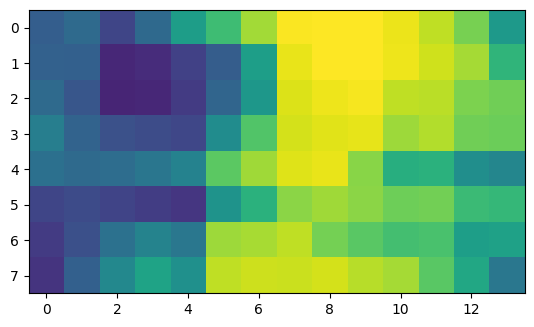

In [24]:
roi = 3
print(p_values[roi].min())
plt.imshow(p_values[roi], vmin=0, vmax=1)

In [12]:
lsn.sweep_responses.shape

(1705, 1234)

In [15]:
lsn.design_matrix.T.reshape(-1, *lsn.image_shape).shape

(3410, 8, 14)

In [34]:
on_template = np.where(lsn.design_matrix[:lsn.n_pixels].T.reshape((-1, *lsn.image_shape)), 255, 0)
off_template = np.where(lsn.design_matrix[lsn.n_pixels:].T.reshape((-1, *lsn.image_shape)), 0, 127)
lsn_template = on_template + off_template
lsn_template.shape

(1705, 8, 14)

In [47]:
responses = lsn.sweep_responses
lsn_template = lsn.frame_images[lsn.stim_table.frame.values]

# chi_square_RFs(responses,LSN_template,num_shuffles=1000)

In [61]:
chi_sq_rfs = chi_square_RFs(responses,lsn_template,num_shuffles=1000)

Making exclusion region masks...
Done.
Building trial matrix...
Done.


In [99]:
is_responsive = np.sum(chi_sq_rfs < 0.05, axis=(1, 2)) > 0
is_responsive.mean()

0.5559157212317666

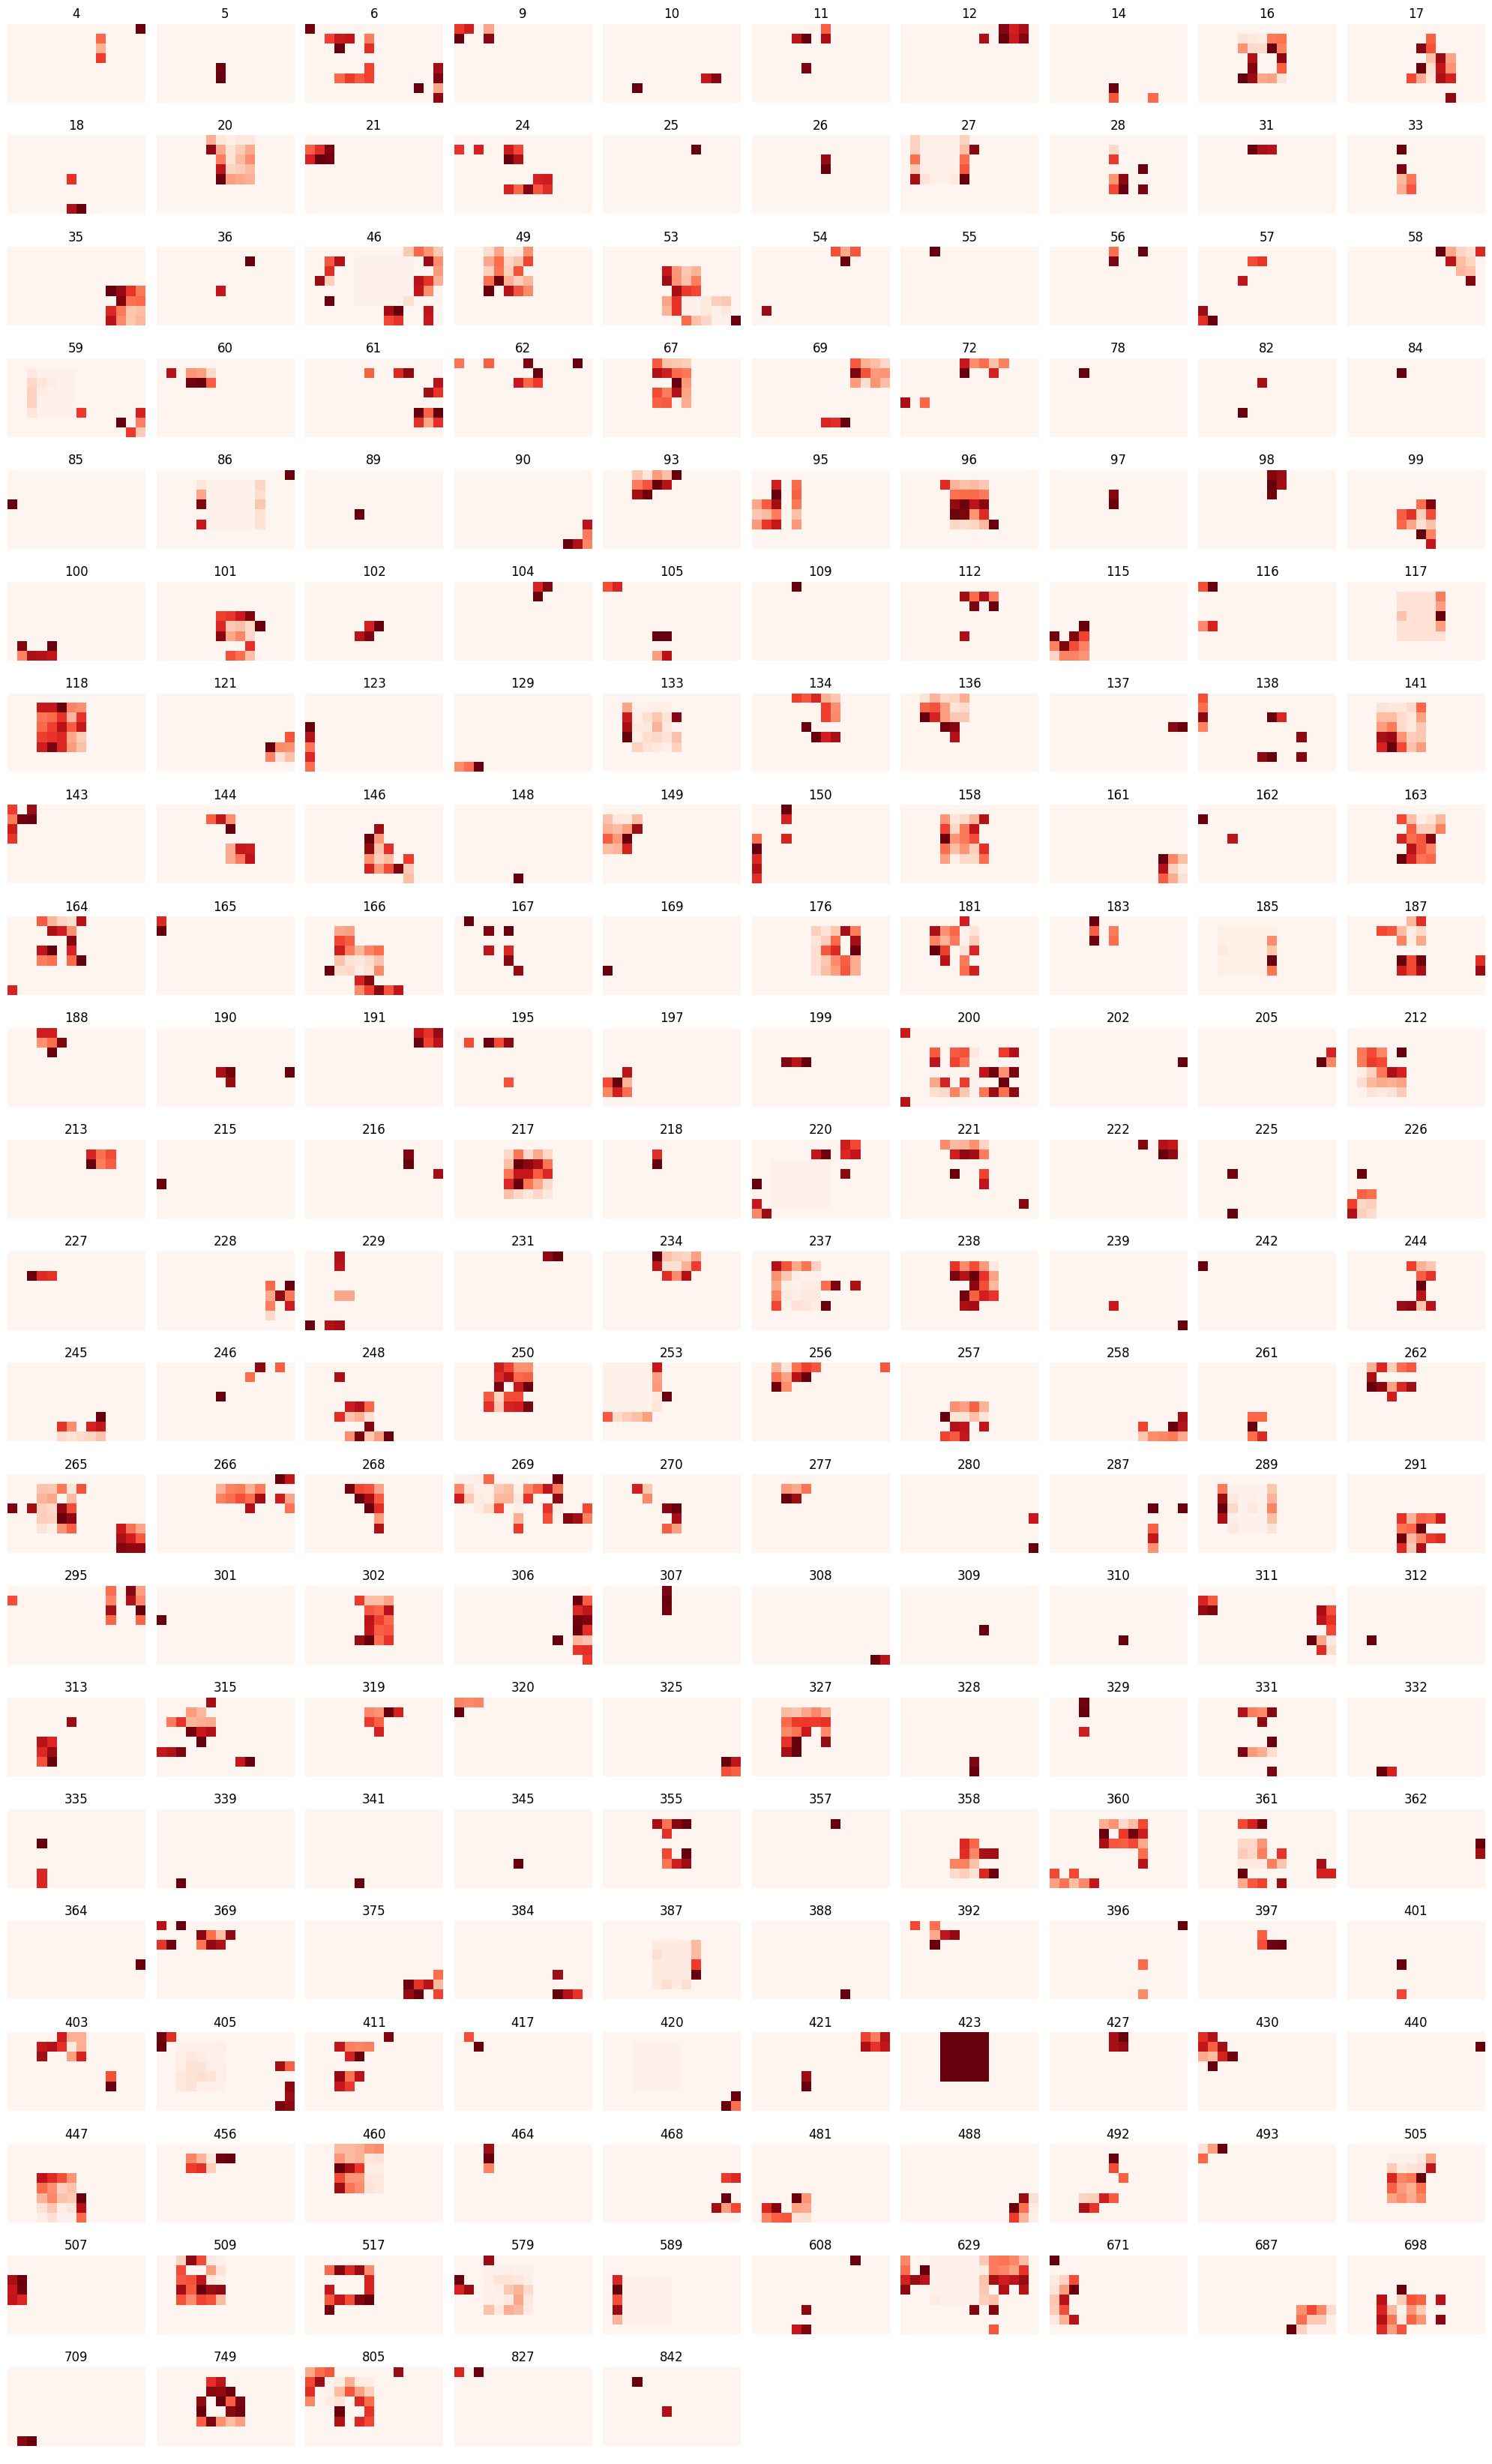

In [101]:
sta = lsn.design_matrix.dot(lsn.sweep_responses) # shape (2*n_pixels, n_rois)
# valid_rois = np.where(lsn.is_roi_valid)[0]
valid_rois = np.where(lsn.is_roi_valid & is_responsive)[0]
plot_on = True
cmap = "Reds" if plot_on else "Blues"
# pixel_idx = slice(lsn.n_pixels) if plot_on else slice(lsn.n_pixels, sta.shape[0])

ncols = 10
nrows = int(np.ceil(len(valid_rois) / ncols))
fig, axs = plt.subplots(figsize=(2*ncols, 1.5*nrows), nrows=nrows, ncols=ncols)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")

    if i < len(valid_rois):
        roi = valid_rois[i]
        rf = chi_sq_rfs[roi] * (chi_sq_rfs[roi] < 0.05)
        # rf = sta[pixel_idx, roi]
        # rf = rf * (p_values_corrected[pixel_idx, roi] < 0.05)
        # rf = rf.reshape(lsn.image_shape)
        
        ax.imshow(rf, cmap=cmap)
        ax.set_title(f"{roi}")
        # ax.set_title(f"{roi} {'ON' if plot_on else 'OFF'}")

# fig.suptitle("ON" if plot_on else "OFF")
fig.tight_layout()